# Perbandingan Random Forest dan Logistic Regression dengan Ekstraksi TF-IDF dan BOW pada Sentimen Analisis Komentar Aplikasi X (Twitter) di Google Play Store

Proyek ini bertujuan untuk menganalisis sentimen dari komentar pengguna aplikasi X (sebelumnya Twitter) di Google Play Store. Analisis ini membandingkan kinerja dua model klasifikasi, yaitu Random Forest dan Logistic Regression, dengan dua teknik ekstraksi fitur yang berbeda, yaitu TF-IDF (Term Frequency-Inverse Document Frequency) dan BOW (Bag of Words). Hasil analisis ini diharapkan dapat memberikan wawasan yang berharga bagi para pemangku kepentingan (stakeholder) dalam memahami umpan balik pengguna, sehingga dapat digunakan untuk pengambilan keputusan yang lebih baik dalam pengembangan dan perbaikan aplikasi.

# Import Library

Pada tahap ini, semua pustaka (library) yang dibutuhkan untuk proyek analisis sentimen diimpor. Pustaka-pustaka ini mencakup berbagai fungsi, mulai dari pengumpulan data, prapemrosesan teks, ekstraksi fitur, hingga pemodelan dan evaluasi.

In [2]:
!pip install google-play-scraper
!pip install sastrawi

In [ ]:
from google_play_scraper import app, reviews, Sort

In [3]:
import csv
import pandas as pd
pd.set_option('mode.chained_assignment', None)

import json
import requests
from io import StringIO

import numpy as np
seed = 0
np.random.seed(seed) # Mengatur seed/titik awal untuk reproduktibilitas

import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [5]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Pengumpulan Data (Scraping Dataset)

Tahap ini berfokus pada pengumpulan data ulasan dari aplikasi X di Google Play Store. Proses scraping terdiri dari:
* Inisialisasi: Sebuah list kosong bernama all_reviews dibuat untuk menampung semua ulasan yang berhasil diambil.
* Pengambilan Data: Proses scraping dilakukan secara berulang (dalam sebuah loop) hingga mencapai target 3000 ulasan. Setiap iterasi mengambil sejumlah ulasan (dalam batch) untuk efisiensi.
* Penyimpanan ke CSV: Setelah semua ulasan terkumpul, data tersebut disimpan ke dalam sebuah file CSV bernama ulasan_x.csv. File ini hanya berisi satu kolom, yaitu 'Review', yang berisi teks dari setiap ulasan.

In [ ]:
all_reviews = []
continuation_token = None
target_count = 3000
batch_size = 200 # Anda bisa menyesuaikan ukuran batch

print(f"Memulai scraping untuk {target_count} ulasan...")

while len(all_reviews) < target_count:
    # Hitung jumlah ulasan yang masih perlu diambil di batch berikutnya
    count_to_fetch = min(batch_size, target_count - len(all_reviews))

    # Panggil fungsi reviews dengan continuation_token jika ada
    result, continuation_token = reviews(
        'com.twitter.android',
        lang='id',
        country='id',
        sort=Sort.MOST_RELEVANT,
        count=count_to_fetch,
        continuation_token=continuation_token
    )

    # Tambahkan ulasan yang didapat ke daftar keseluruhan
    all_reviews.extend(result)

    print(f"Jumlah ulasan yang diambil sejauh ini: {len(all_reviews)}")

    # Hentikan jika tidak ada token kelanjutan lagi (berarti sudah mencapai akhir ulasan)
    if not continuation_token:
        print("Tidak ada token kelanjutan lagi. Mungkin semua ulasan relevan sudah diambil.")
        break

print(f"\nSelesai mengambil {len(all_reviews)} ulasan.")

Memulai scraping untuk 3000 ulasan...
Jumlah ulasan yang diambil sejauh ini: 200
Jumlah ulasan yang diambil sejauh ini: 400
Jumlah ulasan yang diambil sejauh ini: 600
Jumlah ulasan yang diambil sejauh ini: 800
Jumlah ulasan yang diambil sejauh ini: 1000
Jumlah ulasan yang diambil sejauh ini: 1200
Jumlah ulasan yang diambil sejauh ini: 1400
Jumlah ulasan yang diambil sejauh ini: 1600
Jumlah ulasan yang diambil sejauh ini: 1800
Jumlah ulasan yang diambil sejauh ini: 2000
Jumlah ulasan yang diambil sejauh ini: 2200
Jumlah ulasan yang diambil sejauh ini: 2400
Jumlah ulasan yang diambil sejauh ini: 2600
Jumlah ulasan yang diambil sejauh ini: 2800
Jumlah ulasan yang diambil sejauh ini: 3000

Selesai mengambil 3000 ulasan.


In [ ]:
# Menyimpan data kedalam file csv

with open('ulasan_x.csv', mode='w', newline='', encoding='utf-8') as file:
  writer = csv.writer(file)
  writer.writerow(['Review'])
  for review in all_reviews:
    writer.writerow([review['content']])

# Loading Dataset

Setelah data berhasil dikumpulkan dan disimpan, tahap selanjutnya adalah memuat data tersebut ke dalam program untuk dianalisis lebih lanjut.

In [ ]:
reviews_df = pd.read_csv('ulasan_x.csv')
pd.set_option('display.max_colwidth', 3000)
reviews_df

,Review
0,"Semakin banyak updatenya semakin buruk pula cara berjalannya aplikasi. Lagi asik scroll tiba-tiba keluar dengan sendirinya, tiba-tiba keluar dari akun dan mulai login dari awal lagi. Tolong untuk developer untuk memaksimalkan kelancaran aplikasi dan kurangi bug/hapus bug dapat mengganggu para penggunanya."
1,"aplikasi jelek, update malah makin banyak bug nya. entah itu suara video nya delay lah, daftar following/er ilang lah. video ga bisa diputar dll, tolong ini jelek banget update nya tau gitu kembalikan saja ke setelan awal hadehhh"
2,"apk ini semakin lama semakin parah bug nya, saya masuk x dapat verifikasi dan saat saya mau menyelesaikannya halaman tersebut terulang dengan kalimat yang sama lagi setelah saya verifikasi satu tantangan, saya terpaksa harus mendownload ulang.. tetapi itu kembali ngelag dan ngebug lagi! mohon di perbaiki lebih lanjut saya muak jika begini terus."
3,"udah berkali kali sering lag, aku mau login pun susah. lihat thread, gambar, juga susah. setelah ganti jadi X kenapa gini ya, mempersulit banget padahal jaringan koneksi stabil ga ada kesalahan. Ini tolong di perbaiki, ga sekali dua kali loh."
4,"ini x nya gimana sih abis diupdate malah jadi tambh rusak saya lagi ngescrool tiba tiba aja langsung ga keluar sendiri terus saya coba lagi malah gabisa ngeload. Woi, perbaikin x bisa gak? loading lama banget, sok-sokan beli yang ada malah rusak yang ada appnya"
...,...
2995,Tidak bisa membuat album untuk koleksi foto. Dan Tidak seperti Facebook yang bisa membuat album untuk Kumpulan foto. Tampilan masih kaku. Contoh Facebook yang bisa simpan foto di album berbeda. Twitter membosankan tidak seperti Facebook. 👎
2996,gak bisa login blokk
2997,"Banyak bug, tidak bisa penelusuran di Twitter buka foto/video juga banyak bug. Tolong diperbaiki sekalinya update malah banyak bug bukan memperbaiki bug. Makasih"
2998,kenapa gak bisa buat akun woyyy?!?!?!


In [ ]:
# Menampilkan informasi tentang DataFrame reviews_df
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  3000 non-null   object
dtypes: object(1)
memory usage: 23.6+ KB


In [ ]:
# Menampilkan duplikasi data
duplikasi = reviews_df.duplicated().sum()
duplikasi[duplikasi > 0]

array([204])

# Preprocessing Data

Tahap ini merupakan langkah krusial dalam analisis sentimen untuk membersihkan dan mempersiapkan data teks agar siap untuk dianalisis.

Tahap preprocessing data meliputi

* Menghapus Duplikat: Data duplikat yang ditemukan pada tahap sebelumnya dihapus dari DataFrame.
* Case Folding: Semua teks dalam ulasan diubah menjadi huruf kecil (lowercase) untuk memastikan konsistensi.
* Pembersihan Teks (Cleansing): Berbagai elemen yang tidak relevan dihapus dari teks, seperti Mention, Hashtag, URL atau tautan, Angka dan karakter khusus, Tanda baca dan Karakter berulang yang tidak perlu
* Normalisasi Kata (Word Normalization): Kata-kata gaul atau slang diperbaiki dan diubah ke bentuk baku menggunakan sebuah kamus slangword yang dimuat dari file `slangwords.txt`.
* Tokenizing: Teks yang sudah bersih dipecah menjadi unit-unit kecil yang disebut token (dalam hal ini, kata).
* Stopword Removal: Kata-kata umum yang tidak memiliki makna penting (seperti "di", "dan", "yang") dihapus dari daftar token.
* Stemming: Setiap kata dalam token diubah ke bentuk dasarnya menggunakan pustaka Sastrawi.

Tahap pertama adalah menghapus data/review yang duplikat

In [ ]:
reviews_df = reviews_df.drop_duplicates()

Setelah tidak ada review yang duplikat, selanjutnya kita melakukan case folding pada corpus, yaitu merubah semua kata menjadi lowecase (huruf kecil)

In [ ]:
reviews_df['ReviewLower'] = reviews_df['Review'].str.lower()

In [ ]:
reviews_df

,Review,ReviewLower
0,"Semakin banyak updatenya semakin buruk pula cara berjalannya aplikasi. Lagi asik scroll tiba-tiba keluar dengan sendirinya, tiba-tiba keluar dari akun dan mulai login dari awal lagi. Tolong untuk developer untuk memaksimalkan kelancaran aplikasi dan kurangi bug/hapus bug dapat mengganggu para penggunanya.","semakin banyak updatenya semakin buruk pula cara berjalannya aplikasi. lagi asik scroll tiba-tiba keluar dengan sendirinya, tiba-tiba keluar dari akun dan mulai login dari awal lagi. tolong untuk developer untuk memaksimalkan kelancaran aplikasi dan kurangi bug/hapus bug dapat mengganggu para penggunanya."
1,"aplikasi jelek, update malah makin banyak bug nya. entah itu suara video nya delay lah, daftar following/er ilang lah. video ga bisa diputar dll, tolong ini jelek banget update nya tau gitu kembalikan saja ke setelan awal hadehhh","aplikasi jelek, update malah makin banyak bug nya. entah itu suara video nya delay lah, daftar following/er ilang lah. video ga bisa diputar dll, tolong ini jelek banget update nya tau gitu kembalikan saja ke setelan awal hadehhh"
2,"apk ini semakin lama semakin parah bug nya, saya masuk x dapat verifikasi dan saat saya mau menyelesaikannya halaman tersebut terulang dengan kalimat yang sama lagi setelah saya verifikasi satu tantangan, saya terpaksa harus mendownload ulang.. tetapi itu kembali ngelag dan ngebug lagi! mohon di perbaiki lebih lanjut saya muak jika begini terus.","apk ini semakin lama semakin parah bug nya, saya masuk x dapat verifikasi dan saat saya mau menyelesaikannya halaman tersebut terulang dengan kalimat yang sama lagi setelah saya verifikasi satu tantangan, saya terpaksa harus mendownload ulang.. tetapi itu kembali ngelag dan ngebug lagi! mohon di perbaiki lebih lanjut saya muak jika begini terus."
3,"udah berkali kali sering lag, aku mau login pun susah. lihat thread, gambar, juga susah. setelah ganti jadi X kenapa gini ya, mempersulit banget padahal jaringan koneksi stabil ga ada kesalahan. Ini tolong di perbaiki, ga sekali dua kali loh.","udah berkali kali sering lag, aku mau login pun susah. lihat thread, gambar, juga susah. setelah ganti jadi x kenapa gini ya, mempersulit banget padahal jaringan koneksi stabil ga ada kesalahan. ini tolong di perbaiki, ga sekali dua kali loh."
4,"ini x nya gimana sih abis diupdate malah jadi tambh rusak saya lagi ngescrool tiba tiba aja langsung ga keluar sendiri terus saya coba lagi malah gabisa ngeload. Woi, perbaikin x bisa gak? loading lama banget, sok-sokan beli yang ada malah rusak yang ada appnya","ini x nya gimana sih abis diupdate malah jadi tambh rusak saya lagi ngescrool tiba tiba aja langsung ga keluar sendiri terus saya coba lagi malah gabisa ngeload. woi, perbaikin x bisa gak? loading lama banget, sok-sokan beli yang ada malah rusak yang ada appnya"
...,...,...
2995,Tidak bisa membuat album untuk koleksi foto. Dan Tidak seperti Facebook yang bisa membuat album untuk Kumpulan foto. Tampilan masih kaku. Contoh Facebook yang bisa simpan foto di album berbeda. Twitter membosankan tidak seperti Facebook. 👎,tidak bisa membuat album untuk koleksi foto. dan tidak seperti facebook yang bisa membuat album untuk kumpulan foto. tampilan masih kaku. contoh facebook yang bisa simpan foto di album berbeda. twitter membosankan tidak seperti facebook. 👎
2996,gak bisa login blokk,gak bisa login blokk
2997,"Banyak bug, tidak bisa penelusuran di Twitter buka foto/video juga banyak bug. Tolong diperbaiki sekalinya update malah banyak bug bukan memperbaiki bug. Makasih","banyak bug, tidak bisa penelusuran di twitter buka foto/video juga banyak bug. tolong diperbaiki sekalinya update malah banyak bug bukan memperbaiki bug. makasih"
2998,kenapa gak bisa buat akun woyyy?!?!?!,kenapa gak bisa buat akun woyyy?!?!?!


Melakukan proses cleaning atau pembersihan data teks pada kolom ReviewLower dari DataFrame reviews_df (seperti menghapus mention, hashtag, url, spesial karakter, dan lain-lain) agar siap untuk diproses lebih lanjut dalam tahap analisis sentimen.

In [ ]:
# Mengubah garis miring (/) menjadi spasi
reviews_df['ReviewClean'] = reviews_df['ReviewLower'].str.replace(r'/', ' ', regex=True)

# Menghapus mention seperti @username
reviews_df['ReviewClean'] = reviews_df['ReviewClean'].str.replace(r'@[A-Za-z0-9_]+', '', regex=True)

# Menghapus hashtag seperti #topik
reviews_df['ReviewClean'] = reviews_df['ReviewClean'].str.replace(r'#[A-Za-z0-9_]+', '', regex=True)

# Menghapus URL atau link
reviews_df['ReviewClean'] = reviews_df['ReviewClean'].str.replace(r'http\S+', '', regex=True)

# Menghapus angka
reviews_df['ReviewClean'] = reviews_df['ReviewClean'].str.replace(r'[0-9]+', '', regex=True)

# Menghapus karakter khusus selain huruf dan spasi (tapi tetap mempertahankan underscore)
reviews_df['ReviewClean'] = reviews_df['ReviewClean'].str.replace(r'[^\w\s]', '', regex=True)

# Menghapus tanda baca (punctuation) seperti titik, koma, dll
reviews_df['ReviewClean'] = reviews_df['ReviewClean'].str.translate(str.maketrans('', '', string.punctuation))

# Menghapus karakter newline (\n) dan menggantinya dengan spasi
reviews_df['ReviewClean'] = reviews_df['ReviewClean'].str.replace('\n', ' ', regex=False)

# Menghapus spasi di awal dan akhir kalimat
reviews_df['ReviewClean'] = reviews_df['ReviewClean'].str.strip()

# Mengurangi huruf yang diulang lebih dari dua kali menjadi dua kali (contoh: "bangetttt" → "bangett")
reviews_df['ReviewClean'] = reviews_df['ReviewClean'].str.replace(r'([a-zA-Z])\1{2,}', r'\1\1', regex=True)

# Menghapus kata yang diulang dua kali berturut-turut (contoh: "aku aku" → "aku")
reviews_df['ReviewClean'] = reviews_df['ReviewClean'].str.replace(r'\b(\w+)\s+\1\b', r'\1', regex=True)

In [ ]:
reviews_df

,Review,ReviewLower,ReviewClean
0,"Semakin banyak updatenya semakin buruk pula cara berjalannya aplikasi. Lagi asik scroll tiba-tiba keluar dengan sendirinya, tiba-tiba keluar dari akun dan mulai login dari awal lagi. Tolong untuk developer untuk memaksimalkan kelancaran aplikasi dan kurangi bug/hapus bug dapat mengganggu para penggunanya.","semakin banyak updatenya semakin buruk pula cara berjalannya aplikasi. lagi asik scroll tiba-tiba keluar dengan sendirinya, tiba-tiba keluar dari akun dan mulai login dari awal lagi. tolong untuk developer untuk memaksimalkan kelancaran aplikasi dan kurangi bug/hapus bug dapat mengganggu para penggunanya.",semakin banyak updatenya semakin buruk pula cara berjalannya aplikasi lagi asik scroll tibatiba keluar dengan sendirinya tibatiba keluar dari akun dan mulai login dari awal lagi tolong untuk developer untuk memaksimalkan kelancaran aplikasi dan kurangi bug hapus bug dapat mengganggu para penggunanya
1,"aplikasi jelek, update malah makin banyak bug nya. entah itu suara video nya delay lah, daftar following/er ilang lah. video ga bisa diputar dll, tolong ini jelek banget update nya tau gitu kembalikan saja ke setelan awal hadehhh","aplikasi jelek, update malah makin banyak bug nya. entah itu suara video nya delay lah, daftar following/er ilang lah. video ga bisa diputar dll, tolong ini jelek banget update nya tau gitu kembalikan saja ke setelan awal hadehhh",aplikasi jelek update malah makin banyak bug nya entah itu suara video nya delay lah daftar following er ilang lah video ga bisa diputar dll tolong ini jelek banget update nya tau gitu kembalikan saja ke setelan awal hadehh
2,"apk ini semakin lama semakin parah bug nya, saya masuk x dapat verifikasi dan saat saya mau menyelesaikannya halaman tersebut terulang dengan kalimat yang sama lagi setelah saya verifikasi satu tantangan, saya terpaksa harus mendownload ulang.. tetapi itu kembali ngelag dan ngebug lagi! mohon di perbaiki lebih lanjut saya muak jika begini terus.","apk ini semakin lama semakin parah bug nya, saya masuk x dapat verifikasi dan saat saya mau menyelesaikannya halaman tersebut terulang dengan kalimat yang sama lagi setelah saya verifikasi satu tantangan, saya terpaksa harus mendownload ulang.. tetapi itu kembali ngelag dan ngebug lagi! mohon di perbaiki lebih lanjut saya muak jika begini terus.",apk ini semakin lama semakin parah bug nya saya masuk x dapat verifikasi dan saat saya mau menyelesaikannya halaman tersebut terulang dengan kalimat yang sama lagi setelah saya verifikasi satu tantangan saya terpaksa harus mendownload ulang tetapi itu kembali ngelag dan ngebug lagi mohon di perbaiki lebih lanjut saya muak jika begini terus
3,"udah berkali kali sering lag, aku mau login pun susah. lihat thread, gambar, juga susah. setelah ganti jadi X kenapa gini ya, mempersulit banget padahal jaringan koneksi stabil ga ada kesalahan. Ini tolong di perbaiki, ga sekali dua kali loh.","udah berkali kali sering lag, aku mau login pun susah. lihat thread, gambar, juga susah. setelah ganti jadi x kenapa gini ya, mempersulit banget padahal jaringan koneksi stabil ga ada kesalahan. ini tolong di perbaiki, ga sekali dua kali loh.",udah berkali kali sering lag aku mau login pun susah lihat thread gambar juga susah setelah ganti jadi x kenapa gini ya mempersulit banget padahal jaringan koneksi stabil ga ada kesalahan ini tolong di perbaiki ga sekali dua kali loh
4,"ini x nya gimana sih abis diupdate malah jadi tambh rusak saya lagi ngescrool tiba tiba aja langsung ga keluar sendiri terus saya coba lagi malah gabisa ngeload. Woi, perbaikin x bisa gak? loading lama banget, sok-sokan beli yang ada malah rusak yang ada appnya","ini x nya gimana sih abis diupdate malah jadi tambh rusak saya lagi ngescrool tiba tiba aja langsung ga keluar sendiri terus saya coba lagi malah gabisa ngeload. woi, perbaikin x bisa gak? loading lama banget, sok-sokan beli yang ada malah rusak yang ada appnya",ini x nya gimana sih abis diupdate malah jadi tambh rusak

Tahap selanjutnya adalah memperbaiki slangword (kata gaul)



> ini slangword nya dari mana, cari tau



In [ ]:
# Memperbaiki slang words

# Load the slang words from the JSON file
slangwords_dict = {}
slangword = requests.get('https://raw.githubusercontent.com/ramaprakoso/analisis-sentimen/refs/heads/master/kamus/kbba.txt')

# Use StringIO to read the content as a string
slangword_text = StringIO(slangword.text)

for line in slangword_text:
  parts = line.strip().split('\t')
  if len(parts) == 2:
    slang_word = parts[0]
    formal_word = parts[1]

    if slang_word:
      slangwords_dict[slang_word] = formal_word.strip()

In [ ]:
fixed_reviews = []
for review in reviews_df['ReviewClean']:
    words = review.split()
    fixed_words = []
    for word in words:
        if word in slangwords_dict:
            fixed_words.append(slangwords_dict[word])
        else:
            fixed_words.append(word)
    fixed_review = ' '.join(fixed_words)
    fixed_reviews.append(fixed_review)

# Masukkan kembali ke kolom 'Review'
reviews_df['Fix Slang'] = fixed_reviews

In [ ]:
reviews_df

,Review,ReviewLower,ReviewClean,Fix Slang
0,"Semakin banyak updatenya semakin buruk pula cara berjalannya aplikasi. Lagi asik scroll tiba-tiba keluar dengan sendirinya, tiba-tiba keluar dari akun dan mulai login dari awal lagi. Tolong untuk developer untuk memaksimalkan kelancaran aplikasi dan kurangi bug/hapus bug dapat mengganggu para penggunanya.","semakin banyak updatenya semakin buruk pula cara berjalannya aplikasi. lagi asik scroll tiba-tiba keluar dengan sendirinya, tiba-tiba keluar dari akun dan mulai login dari awal lagi. tolong untuk developer untuk memaksimalkan kelancaran aplikasi dan kurangi bug/hapus bug dapat mengganggu para penggunanya.",semakin banyak updatenya semakin buruk pula cara berjalannya aplikasi lagi asik scroll tibatiba keluar dengan sendirinya tibatiba keluar dari akun dan mulai login dari awal lagi tolong untuk developer untuk memaksimalkan kelancaran aplikasi dan kurangi bug hapus bug dapat mengganggu para penggunanya,semakin banyak updatenya semakin buruk pula cara berjalannya aplikasi lagi asik scroll tibatiba keluar dengan sendirinya tibatiba keluar dari akun dan mulai login dari awal lagi tolong untuk developer untuk memaksimalkan kelancaran aplikasi dan kurangi bug hapus bug dapat mengganggu para penggunanya
1,"aplikasi jelek, update malah makin banyak bug nya. entah itu suara video nya delay lah, daftar following/er ilang lah. video ga bisa diputar dll, tolong ini jelek banget update nya tau gitu kembalikan saja ke setelan awal hadehhh","aplikasi jelek, update malah makin banyak bug nya. entah itu suara video nya delay lah, daftar following/er ilang lah. video ga bisa diputar dll, tolong ini jelek banget update nya tau gitu kembalikan saja ke setelan awal hadehhh",aplikasi jelek update malah makin banyak bug nya entah itu suara video nya delay lah daftar following er ilang lah video ga bisa diputar dll tolong ini jelek banget update nya tau gitu kembalikan saja ke setelan awal hadehh,aplikasi jelek update bahkan makin banyak bug nya entah itu suara video nya delay lah daftar following er hilang lah video tidak bisa diputar dan lain-lain tolong ini jelek banget update nya tahu begitu kembalikan saja ke setelan awal hadehh
2,"apk ini semakin lama semakin parah bug nya, saya masuk x dapat verifikasi dan saat saya mau menyelesaikannya halaman tersebut terulang dengan kalimat yang sama lagi setelah saya verifikasi satu tantangan, saya terpaksa harus mendownload ulang.. tetapi itu kembali ngelag dan ngebug lagi! mohon di perbaiki lebih lanjut saya muak jika begini terus.","apk ini semakin lama semakin parah bug nya, saya masuk x dapat verifikasi dan saat saya mau menyelesaikannya halaman tersebut terulang dengan kalimat yang sama lagi setelah saya verifikasi satu tantangan, saya terpaksa harus mendownload ulang.. tetapi itu kembali ngelag dan ngebug lagi! mohon di perbaiki lebih lanjut saya muak jika begini terus.",apk ini semakin lama semakin parah bug nya saya masuk x dapat verifikasi dan saat saya mau menyelesaikannya halaman tersebut terulang dengan kalimat yang sama lagi setelah saya verifikasi satu tantangan saya terpaksa harus mendownload ulang tetapi itu kembali ngelag dan ngebug lagi mohon di perbaiki lebih lanjut saya muak jika begini terus,apk ini semakin lama semakin parah bug nya saya masuk x dapat verifikasi dan saat saya mau menyelesaikannya halaman tersebut terulang dengan kalimat yang sama lagi setelah saya verifikasi satu tantangan saya terpaksa harus mendownload ulang tetapi itu kembali ngelag dan ngebug lagi mohon di perbaiki lebih lanjut saya muak jika begini terus
3,"udah berkali kali sering lag, aku mau login pun susah. lihat thread, gambar, juga susah. setelah ganti jadi X kenapa gini ya, mempersulit banget padahal jaringan koneksi stabil ga ada kesalahan. Ini tolong di perbaiki, ga sekali dua kali loh.","udah berkali kali sering lag, aku mau login pun susah. lihat thread, gambar, juga susah. setelah ganti jadi x kenapa gini ya, mempersulit banget padahal jaringan koneksi 

### Tokenizing

Tahap tokenizing memecah teks menjadi unit-unit kecil yang disebut token. Token bisa berupa kata, kalimat, atau simbol tergantung pada kebutuhan.

In [ ]:
reviews_df['Tokenized'] = reviews_df['Fix Slang'].apply(word_tokenize)

In [ ]:
reviews_df

,Review,ReviewLower,ReviewClean,Fix Slang,Tokenized
0,"Semakin banyak updatenya semakin buruk pula cara berjalannya aplikasi. Lagi asik scroll tiba-tiba keluar dengan sendirinya, tiba-tiba keluar dari akun dan mulai login dari awal lagi. Tolong untuk developer untuk memaksimalkan kelancaran aplikasi dan kurangi bug/hapus bug dapat mengganggu para penggunanya.","semakin banyak updatenya semakin buruk pula cara berjalannya aplikasi. lagi asik scroll tiba-tiba keluar dengan sendirinya, tiba-tiba keluar dari akun dan mulai login dari awal lagi. tolong untuk developer untuk memaksimalkan kelancaran aplikasi dan kurangi bug/hapus bug dapat mengganggu para penggunanya.",semakin banyak updatenya semakin buruk pula cara berjalannya aplikasi lagi asik scroll tibatiba keluar dengan sendirinya tibatiba keluar dari akun dan mulai login dari awal lagi tolong untuk developer untuk memaksimalkan kelancaran aplikasi dan kurangi bug hapus bug dapat mengganggu para penggunanya,semakin banyak updatenya semakin buruk pula cara berjalannya aplikasi lagi asik scroll tibatiba keluar dengan sendirinya tibatiba keluar dari akun dan mulai login dari awal lagi tolong untuk developer untuk memaksimalkan kelancaran aplikasi dan kurangi bug hapus bug dapat mengganggu para penggunanya,"[semakin, banyak, updatenya, semakin, buruk, pula, cara, berjalannya, aplikasi, lagi, asik, scroll, tibatiba, keluar, dengan, sendirinya, tibatiba, keluar, dari, akun, dan, mulai, login, dari, awal, lagi, tolong, untuk, developer, untuk, memaksimalkan, kelancaran, aplikasi, dan, kurangi, bug, hapus, bug, dapat, mengganggu, para, penggunanya]"
1,"aplikasi jelek, update malah makin banyak bug nya. entah itu suara video nya delay lah, daftar following/er ilang lah. video ga bisa diputar dll, tolong ini jelek banget update nya tau gitu kembalikan saja ke setelan awal hadehhh","aplikasi jelek, update malah makin banyak bug nya. entah itu suara video nya delay lah, daftar following/er ilang lah. video ga bisa diputar dll, tolong ini jelek banget update nya tau gitu kembalikan saja ke setelan awal hadehhh",aplikasi jelek update malah makin banyak bug nya entah itu suara video nya delay lah daftar following er ilang lah video ga bisa diputar dll tolong ini jelek banget update nya tau gitu kembalikan saja ke setelan awal hadehh,aplikasi jelek update bahkan makin banyak bug nya entah itu suara video nya delay lah daftar following er hilang lah video tidak bisa diputar dan lain-lain tolong ini jelek banget update nya tahu begitu kembalikan saja ke setelan awal hadehh,"[aplikasi, jelek, update, bahkan, makin, banyak, bug, nya, entah, itu, suara, video, nya, delay, lah, daftar, following, er, hilang, lah, video, tidak, bisa, diputar, dan, lain-lain, tolong, ini, jelek, banget, update, nya, tahu, begitu, kembalikan, saja, ke, setelan, awal, hadehh]"
2,"apk ini semakin lama semakin parah bug nya, saya masuk x dapat verifikasi dan saat saya mau menyelesaikannya halaman tersebut terulang dengan kalimat yang sama lagi setelah saya verifikasi satu tantangan, saya terpaksa harus mendownload ulang.. tetapi itu kembali ngelag dan ngebug lagi! mohon di perbaiki lebih lanjut saya muak jika begini terus.","apk ini semakin lama semakin parah bug nya, saya masuk x dapat verifikasi dan saat saya mau menyelesaikannya halaman tersebut terulang dengan kalimat yang sama lagi setelah saya verifikasi satu tantangan, saya terpaksa harus mendownload ulang.. tetapi itu kembali ngelag dan ngebug lagi! mohon di perbaiki lebih lanjut saya muak jika begini terus.",apk ini semakin lama semakin parah bug nya saya masuk x dapat verifikasi dan saat saya mau menyelesaikannya halaman tersebut terulang dengan kalimat yang sama lagi setelah saya verifikasi satu tantangan saya terpaksa harus mendownload ulang tetapi itu kembali ngelag dan ngebug lagi mohon di perbaiki lebih lanjut saya muak jika begini terus,apk ini semakin lama semakin parah bug nya saya masuk x dapat verifikasi dan saat saya mau menyelesaikannya halaman ter

### Stopword Removal

Kata-kata umum dalam suatu bahasa yang biasanya tidak memiliki makna penting secara analisis, akan dihapus dalam pemrosesan teks

In [ ]:
list_stopwords = set(stopwords.words('indonesian'))
list_stopwords_eng = set(stopwords.words('english'))
list_stopwords.update(list_stopwords_eng)
list_stopwords.update(['iya','yaa','gak','nya','na','sih','ku','di','ga','ya','gaa','loh','kah','woi','woii','woy', 'ah', 'yah'])

reviews_df['Stopword'] = reviews_df['Tokenized'].apply(lambda tokens: [word for word in tokens if word not in list_stopwords])

In [ ]:
reviews_df

,Review,ReviewLower,ReviewClean,Fix Slang,Tokenized,Stopword
0,"Semakin banyak updatenya semakin buruk pula cara berjalannya aplikasi. Lagi asik scroll tiba-tiba keluar dengan sendirinya, tiba-tiba keluar dari akun dan mulai login dari awal lagi. Tolong untuk developer untuk memaksimalkan kelancaran aplikasi dan kurangi bug/hapus bug dapat mengganggu para penggunanya.","semakin banyak updatenya semakin buruk pula cara berjalannya aplikasi. lagi asik scroll tiba-tiba keluar dengan sendirinya, tiba-tiba keluar dari akun dan mulai login dari awal lagi. tolong untuk developer untuk memaksimalkan kelancaran aplikasi dan kurangi bug/hapus bug dapat mengganggu para penggunanya.",semakin banyak updatenya semakin buruk pula cara berjalannya aplikasi lagi asik scroll tibatiba keluar dengan sendirinya tibatiba keluar dari akun dan mulai login dari awal lagi tolong untuk developer untuk memaksimalkan kelancaran aplikasi dan kurangi bug hapus bug dapat mengganggu para penggunanya,semakin banyak updatenya semakin buruk pula cara berjalannya aplikasi lagi asik scroll tibatiba keluar dengan sendirinya tibatiba keluar dari akun dan mulai login dari awal lagi tolong untuk developer untuk memaksimalkan kelancaran aplikasi dan kurangi bug hapus bug dapat mengganggu para penggunanya,"[semakin, banyak, updatenya, semakin, buruk, pula, cara, berjalannya, aplikasi, lagi, asik, scroll, tibatiba, keluar, dengan, sendirinya, tibatiba, keluar, dari, akun, dan, mulai, login, dari, awal, lagi, tolong, untuk, developer, untuk, memaksimalkan, kelancaran, aplikasi, dan, kurangi, bug, hapus, bug, dapat, mengganggu, para, penggunanya]","[updatenya, buruk, berjalannya, aplikasi, asik, scroll, tibatiba, tibatiba, akun, login, tolong, developer, memaksimalkan, kelancaran, aplikasi, kurangi, bug, hapus, bug, mengganggu, penggunanya]"
1,"aplikasi jelek, update malah makin banyak bug nya. entah itu suara video nya delay lah, daftar following/er ilang lah. video ga bisa diputar dll, tolong ini jelek banget update nya tau gitu kembalikan saja ke setelan awal hadehhh","aplikasi jelek, update malah makin banyak bug nya. entah itu suara video nya delay lah, daftar following/er ilang lah. video ga bisa diputar dll, tolong ini jelek banget update nya tau gitu kembalikan saja ke setelan awal hadehhh",aplikasi jelek update malah makin banyak bug nya entah itu suara video nya delay lah daftar following er ilang lah video ga bisa diputar dll tolong ini jelek banget update nya tau gitu kembalikan saja ke setelan awal hadehh,aplikasi jelek update bahkan makin banyak bug nya entah itu suara video nya delay lah daftar following er hilang lah video tidak bisa diputar dan lain-lain tolong ini jelek banget update nya tahu begitu kembalikan saja ke setelan awal hadehh,"[aplikasi, jelek, update, bahkan, makin, banyak, bug, nya, entah, itu, suara, video, nya, delay, lah, daftar, following, er, hilang, lah, video, tidak, bisa, diputar, dan, lain-lain, tolong, ini, jelek, banget, update, nya, tahu, begitu, kembalikan, saja, ke, setelan, awal, hadehh]","[aplikasi, jelek, update, bug, suara, video, delay, daftar, following, er, hilang, video, diputar, lain-lain, tolong, jelek, banget, update, kembalikan, setelan, hadehh]"
2,"apk ini semakin lama semakin parah bug nya, saya masuk x dapat verifikasi dan saat saya mau menyelesaikannya halaman tersebut terulang dengan kalimat yang sama lagi setelah saya verifikasi satu tantangan, saya terpaksa harus mendownload ulang.. tetapi itu kembali ngelag dan ngebug lagi! mohon di perbaiki lebih lanjut saya muak jika begini terus.","apk ini semakin lama semakin parah bug nya, saya masuk x dapat verifikasi dan saat saya mau menyelesaikannya halaman tersebut terulang dengan kalimat yang sama lagi setelah saya verifikasi satu tantangan, saya terpaksa harus mendownload ulang.. tetapi itu kembali ngelag dan ngebug lagi! mohon di perbaiki lebih lanjut saya muak jika begini terus.",apk ini semakin lama semakin parah bug nya saya masuk x dapat verifikasi dan saat 

## Stemming

Stemming adalah proses mengubah sebuah kata ke bentuk dasarnya (root word) dengan cara menghapus imbuhan (awalan, akhiran, sisipan).

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

reviews_df['Stemmed_Text'] = reviews_df['Stopword'].apply(lambda tokens: stemmer.stem(' '.join(tokens)))

In [ ]:
reviews_df

,Review,ReviewLower,ReviewClean,Fix Slang,Tokenized,Stopword,Stemmed_Text
0,"Semakin banyak updatenya semakin buruk pula cara berjalannya aplikasi. Lagi asik scroll tiba-tiba keluar dengan sendirinya, tiba-tiba keluar dari akun dan mulai login dari awal lagi. Tolong untuk developer untuk memaksimalkan kelancaran aplikasi dan kurangi bug/hapus bug dapat mengganggu para penggunanya.","semakin banyak updatenya semakin buruk pula cara berjalannya aplikasi. lagi asik scroll tiba-tiba keluar dengan sendirinya, tiba-tiba keluar dari akun dan mulai login dari awal lagi. tolong untuk developer untuk memaksimalkan kelancaran aplikasi dan kurangi bug/hapus bug dapat mengganggu para penggunanya.",semakin banyak updatenya semakin buruk pula cara berjalannya aplikasi lagi asik scroll tibatiba keluar dengan sendirinya tibatiba keluar dari akun dan mulai login dari awal lagi tolong untuk developer untuk memaksimalkan kelancaran aplikasi dan kurangi bug hapus bug dapat mengganggu para penggunanya,semakin banyak updatenya semakin buruk pula cara berjalannya aplikasi lagi asik scroll tibatiba keluar dengan sendirinya tibatiba keluar dari akun dan mulai login dari awal lagi tolong untuk developer untuk memaksimalkan kelancaran aplikasi dan kurangi bug hapus bug dapat mengganggu para penggunanya,"[semakin, banyak, updatenya, semakin, buruk, pula, cara, berjalannya, aplikasi, lagi, asik, scroll, tibatiba, keluar, dengan, sendirinya, tibatiba, keluar, dari, akun, dan, mulai, login, dari, awal, lagi, tolong, untuk, developer, untuk, memaksimalkan, kelancaran, aplikasi, dan, kurangi, bug, hapus, bug, dapat, mengganggu, para, penggunanya]","[updatenya, buruk, berjalannya, aplikasi, asik, scroll, tibatiba, tibatiba, akun, login, tolong, developer, memaksimalkan, kelancaran, aplikasi, kurangi, bug, hapus, bug, mengganggu, penggunanya]",updatenya buruk jalan aplikasi asik scroll tibatiba tibatiba akun login tolong developer maksimal lancar aplikasi kurang bug hapus bug ganggu guna
1,"aplikasi jelek, update malah makin banyak bug nya. entah itu suara video nya delay lah, daftar following/er ilang lah. video ga bisa diputar dll, tolong ini jelek banget update nya tau gitu kembalikan saja ke setelan awal hadehhh","aplikasi jelek, update malah makin banyak bug nya. entah itu suara video nya delay lah, daftar following/er ilang lah. video ga bisa diputar dll, tolong ini jelek banget update nya tau gitu kembalikan saja ke setelan awal hadehhh",aplikasi jelek update malah makin banyak bug nya entah itu suara video nya delay lah daftar following er ilang lah video ga bisa diputar dll tolong ini jelek banget update nya tau gitu kembalikan saja ke setelan awal hadehh,aplikasi jelek update bahkan makin banyak bug nya entah itu suara video nya delay lah daftar following er hilang lah video tidak bisa diputar dan lain-lain tolong ini jelek banget update nya tahu begitu kembalikan saja ke setelan awal hadehh,"[aplikasi, jelek, update, bahkan, makin, banyak, bug, nya, entah, itu, suara, video, nya, delay, lah, daftar, following, er, hilang, lah, video, tidak, bisa, diputar, dan, lain-lain, tolong, ini, jelek, banget, update, nya, tahu, begitu, kembalikan, saja, ke, setelan, awal, hadehh]","[aplikasi, jelek, update, bug, suara, video, delay, daftar, following, er, hilang, video, diputar, lain-lain, tolong, jelek, banget, update, kembalikan, setelan, hadehh]",aplikasi jelek update bug suara video delay daftar following er hilang video putar lain tolong jelek banget update kembali setel hadehh
2,"apk ini semakin lama semakin parah bug nya, saya masuk x dapat verifikasi dan saat saya mau menyelesaikannya halaman tersebut terulang dengan kalimat yang sama lagi setelah saya verifikasi satu tantangan, saya terpaksa harus mendownload ulang.. tetapi itu kembali ngelag dan ngebug lagi! mohon di perbaiki lebih lanjut saya muak jika begini terus.","apk ini semakin lama semakin parah bug nya, saya masuk x dapat verifikasi dan saat saya mau menyelesaikannya halaman tersebut terulang 

Menyimpan data yang telah dilakuakn preprocessing

In [ ]:
reviews_df.to_csv('ulasan_x_preprocessing.csv', index=False)

In [12]:
reviews_df = pd.read_csv('ulasan_x_preprocessing.csv')
pd.set_option('display.max_colwidth', 3000)

# Pelabelan Teks

Pada tahap ini, setiap ulasan yang telah diproses diberi label sentimen (positif atau negatif) berdasarkan skor polaritas.

* Pengambilan Leksikon: Data leksikon (kamus kata) positif dan negatif diambil dari repositori GitHub. Leksikon ini berisi kata-kata beserta skor sentimennya.
* Perhitungan Skor Sentimen: Sebuah fungsi bernama `get_sentiment_score` dibuat untuk menghitung skor sentimen setiap ulasan. Fungsi ini menjumlahkan skor dari setiap kata dalam ulasan berdasarkan leksikon yang ada.
* Pelabelan Polaritas: Berdasarkan skor yang dihitung, setiap ulasan diberi label:
  * `positive`: Jika skor lebih besar dari atau sama dengan 0.
  * `negative`: Jika skor kurang dari 0.

In [13]:
# Loads positive lexicon data from GitHub

lexicon_positive = dict()
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')

    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")

# Loads negative lexicon data from GitHub

lexicon_negative = dict()
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')

    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")

Membuat fungsi untuk pelabelan data pada teks denga lexicon yang telah di ambil di atas

In [14]:
def get_sentiment_score(text):
    score = 0
    for word in text:
        if word in lexicon_positive:
            score += lexicon_positive[word]
        elif word in lexicon_negative:
            score += lexicon_negative[word]
    return score

Melakukan tokenisasi ulang dari kata yang sudah di stemming

In [15]:
reviews_df['tokens2'] = reviews_df['Stemmed_Text'].astype(str).apply(word_tokenize)

Melakukan pelabelan pada teks dengan menghitung skor sentimen dan menentukan polaritas berdasarkan skor

In [16]:
reviews_df['polarity_score'] = reviews_df['tokens2'].apply(get_sentiment_score)

reviews_df['polarity'] = reviews_df['polarity_score'].apply(
    lambda x: 'positive' if x >= 0 else 'negative'
)

In [17]:
reviews_df

,Review,ReviewLower,ReviewClean,Fix Slang,Tokenized,Stopword,Stemmed_Text,tokens2,polarity_score,polarity
0,"Semakin banyak updatenya semakin buruk pula cara berjalannya aplikasi. Lagi asik scroll tiba-tiba keluar dengan sendirinya, tiba-tiba keluar dari akun dan mulai login dari awal lagi. Tolong untuk developer untuk memaksimalkan kelancaran aplikasi dan kurangi bug/hapus bug dapat mengganggu para penggunanya.","semakin banyak updatenya semakin buruk pula cara berjalannya aplikasi. lagi asik scroll tiba-tiba keluar dengan sendirinya, tiba-tiba keluar dari akun dan mulai login dari awal lagi. tolong untuk developer untuk memaksimalkan kelancaran aplikasi dan kurangi bug/hapus bug dapat mengganggu para penggunanya.",semakin banyak updatenya semakin buruk pula cara berjalannya aplikasi lagi asik scroll tibatiba keluar dengan sendirinya tibatiba keluar dari akun dan mulai login dari awal lagi tolong untuk developer untuk memaksimalkan kelancaran aplikasi dan kurangi bug hapus bug dapat mengganggu para penggunanya,semakin banyak updatenya semakin buruk pula cara berjalannya aplikasi lagi asik scroll tibatiba keluar dengan sendirinya tibatiba keluar dari akun dan mulai login dari awal lagi tolong untuk developer untuk memaksimalkan kelancaran aplikasi dan kurangi bug hapus bug dapat mengganggu para penggunanya,"['semakin', 'banyak', 'updatenya', 'semakin', 'buruk', 'pula', 'cara', 'berjalannya', 'aplikasi', 'lagi', 'asik', 'scroll', 'tibatiba', 'keluar', 'dengan', 'sendirinya', 'tibatiba', 'keluar', 'dari', 'akun', 'dan', 'mulai', 'login', 'dari', 'awal', 'lagi', 'tolong', 'untuk', 'developer', 'untuk', 'memaksimalkan', 'kelancaran', 'aplikasi', 'dan', 'kurangi', 'bug', 'hapus', 'bug', 'dapat', 'mengganggu', 'para', 'penggunanya']","['updatenya', 'buruk', 'berjalannya', 'aplikasi', 'asik', 'scroll', 'tibatiba', 'tibatiba', 'akun', 'login', 'tolong', 'developer', 'memaksimalkan', 'kelancaran', 'aplikasi', 'kurangi', 'bug', 'hapus', 'bug', 'mengganggu', 'penggunanya']",updatenya buruk jalan aplikasi asik scroll tibatiba tibatiba akun login tolong developer maksimal lancar aplikasi kurang bug hapus bug ganggu guna,"[updatenya, buruk, jalan, aplikasi, asik, scroll, tibatiba, tibatiba, akun, login, tolong, developer, maksimal, lancar, aplikasi, kurang, bug, hapus, bug, ganggu, guna]",-8,negative
1,"aplikasi jelek, update malah makin banyak bug nya. entah itu suara video nya delay lah, daftar following/er ilang lah. video ga bisa diputar dll, tolong ini jelek banget update nya tau gitu kembalikan saja ke setelan awal hadehhh","aplikasi jelek, update malah makin banyak bug nya. entah itu suara video nya delay lah, daftar following/er ilang lah. video ga bisa diputar dll, tolong ini jelek banget update nya tau gitu kembalikan saja ke setelan awal hadehhh",aplikasi jelek update malah makin banyak bug nya entah itu suara video nya delay lah daftar following er ilang lah video ga bisa diputar dll tolong ini jelek banget update nya tau gitu kembalikan saja ke setelan awal hadehh,aplikasi jelek update bahkan makin banyak bug nya entah itu suara video nya delay lah daftar following er hilang lah video tidak bisa diputar dan lain-lain tolong ini jelek banget update nya tahu begitu kembalikan saja ke setelan awal hadehh,"['aplikasi', 'jelek', 'update', 'bahkan', 'makin', 'banyak', 'bug', 'nya', 'entah', 'itu', 'suara', 'video', 'nya', 'delay', 'lah', 'daftar', 'following', 'er', 'hilang', 'lah', 'video', 'tidak', 'bisa', 'diputar', 'dan', 'lain-lain', 'tolong', 'ini', 'jelek', 'banget', 'update', 'nya', 'tahu', 'begitu', 'kembalikan', 'saja', 'ke', 'setelan', 'awal', 'hadehh']","['aplikasi', 'jelek', 'update', 'bug', 'suara', 'video', 'delay', 'daftar', 'following', 'er', 'hilang', 'video', 'diputar', 'lain-lain', 'tolong', 'jelek', 'banget', 'update', 'kembalikan', 'setelan', 'hadehh']",aplikasi jelek update bug suara video delay daftar following er hilang video putar lain tolong jelek banget update kembali setel hadehh,"[aplikasi, jelek, update

In [18]:
reviews_df['polarity'].value_counts()

,count
polarity,
positive,1739
negative,1057


# Extraksi Fitur

Setelah pelabelan, teks perlu diubah menjadi format numerik agar dapat diproses oleh model machine learning. Tahap ini membandingkan dua teknik ekstraksi fitur.

Sebelum memasuki proses ekstraksi fitur, data di pisahkan menjadi fitur dan target

In [19]:
reviews_df = reviews_df.dropna()

In [20]:
x = reviews_df['Stemmed_Text']
y = reviews_df['polarity']

TF-IDF adalah metode statistik yang mengukur pentingnya sebuah kata dalam sebuah dokumen dalam konteks seluruh korpus (kumpulan dokumen).

* Proses: `TfidfVectorizer` dari scikit-learn digunakan untuk mengubah teks menjadi matriks fitur TF-IDF.
*Hasil: Data teks diubah menjadi representasi numerik yang siap digunakan untuk melatih model.

In [21]:
# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(max_features=800, min_df=5, max_df=0.8)
X_tfidf = tfidf.fit_transform(x)

# Konversi hasil ekstraksi fitur menjadi dataframe
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Menampilkan hasil ekstraksi fitur
features_df

,acak,accord,account,admin,aduh,ajar,aju,akhirakhir,akses,aktif,...,vid,video,vidio,wa,wajib,wawas,web,wifi,youtube,yt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.279768,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2790,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.175867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2792,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Bag of Words (BoW) dengan Count Vectorizer

BoW adalah pendekatan yang lebih sederhana di mana teks direpresentasikan sebagai kumpulan kata tanpa memperhatikan urutan.
* Proses: CountVectorizer dari scikit-learn digunakan untuk menghitung frekuensi kemunculan setiap kata dalam dokumen.
* Hasil: Data teks diubah menjadi vektor frekuensi kata.

In [22]:
# Ekstraksi fitur dengan Count Vectorizer
vectorizer = CountVectorizer(max_features=1500, ngram_range=(1,2), min_df=5, max_df=0.8)
X_vectorizer = vectorizer.fit_transform(x)

# Konversi hasil ekstraksi fitur menjadi dataframe
features_df = pd.DataFrame(X_vectorizer.toarray(), columns=vectorizer.get_feature_names_out())

# Menampilkan hasil ekstraksi fitur
features_df

,acak,accord,account,admin,aduh,ajar,aju,aju banding,akhirakhir,akses,...,wawas,web,wifi,wifi bagus,wifi data,wifi jaring,wifi lancar,youtube,youtube lancar,yt
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2789,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2790,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2791,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2792,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Resampling dengan SMOTE

Karena data sentimen tidak seimbang (jumlah ulasan positif dan negatif berbeda), teknik SMOTE (Synthetic Minority Over-sampling Technique) digunakan untuk menyeimbangkan distribusi kelas pada data pelatihan. Ini dilakukan dengan membuat sampel sintetis dari kelas minoritas.

## Resample untuk teknik ekstraksi TF-IDF

Langkah pertama sebelum melakukan oversampling adalah melakukan encoder pada label

In [23]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)

melakukan spliting pada dataset yang telah di ekstrak dengan TF-IDF

In [24]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

melakukan SMOTE pada data training

In [25]:
smote_tfidf = SMOTE(random_state=42)

X_train_tfidf_smote, y_train_tfidf_smote = smote_tfidf.fit_resample(X_train_tfidf, y_train_tfidf)

print("Jumlah kelas setelah SMOTE (TF-IDF): ", Counter(y_train_tfidf_smote))

Jumlah kelas setelah SMOTE (TF-IDF):  Counter({np.int64(0): 1389, np.int64(1): 1389})


## Resample untuk teknik ekstraksi Bag of Word

melakukan spliting pada dataset yang telah di ekstrak dengan bag of word

In [26]:
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_vectorizer, y, test_size=0.2, random_state=42, stratify=y)

melakukan SMOTE pada data training

In [27]:
smote_CV = SMOTE(random_state=42)

X_train_cv_smote, y_train_cv_smote = smote_CV.fit_resample(X_train_cv, y_train_cv)

print("Jumlah kelas setelah SMOTE (Count Vectorizer): ", Counter(y_train_cv_smote))

Jumlah kelas setelah SMOTE (Count Vectorizer):  Counter({np.int64(0): 1389, np.int64(1): 1389})


Membuat visualisasi untuk melihat distribusi kelas pada data tanpa di resample menggunakan smote

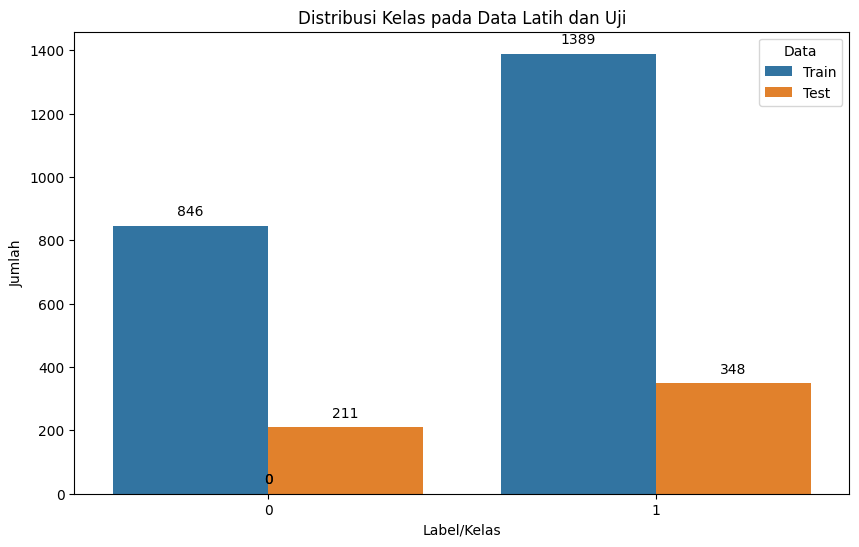

In [28]:
# Gabungkan data latih dan uji
combined_dist = pd.concat([
    pd.DataFrame({'Label': y_train_tfidf, 'Data': 'Train'}),
    pd.DataFrame({'Label': y_test_tfidf, 'Data': 'Test'})
])

# Plot distribusi label
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=combined_dist, x='Label', hue='Data')

# Tambahkan jumlah di atas bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10), textcoords='offset points')

# Tambahkan judul dan label sumbu
plt.title('Distribusi Kelas pada Data Latih dan Uji')
plt.xlabel('Label/Kelas')
plt.ylabel('Jumlah')
plt.show()

Membuat visualisasi untuk melihat distribusi kelas pada data yang telah di resample menggunakan smote

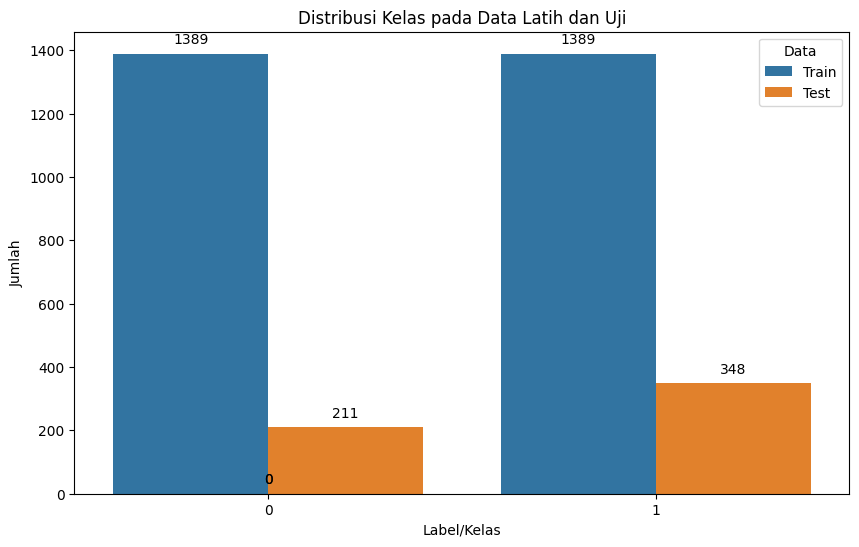

In [29]:
# Gabungkan data latih dan uji
combined_dist = pd.concat([
    pd.DataFrame({'Label': y_train_tfidf_smote, 'Data': 'Train'}),
    pd.DataFrame({'Label': y_test_tfidf, 'Data': 'Test'})
])

# Plot distribusi label
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=combined_dist, x='Label', hue='Data')

# Tambahkan jumlah di atas bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10), textcoords='offset points')

# Tambahkan judul dan label sumbu
plt.title('Distribusi Kelas pada Data Latih dan Uji')
plt.xlabel('Label/Kelas')
plt.ylabel('Jumlah')
plt.show()

# Analisis Sentimen Tanpa SMOTE

Analisis sentimen adalah tahap inti dalam proyek ini dimana model machine learning dilatih dan dievaluasi menggunakan data yang telah diproses.

### Modeling dengan algoritma Logistic Regression

Model Logistic Regression dilatih menggunakan data hasil ekstraksi fitur TF-IDF. Setelah dilatih model diuji dengan memprediksi sentimen pada data uji

In [30]:
logistic_regression = LogisticRegression(C=4, penalty='l1', solver='liblinear')
logistic_regression.fit(X_train_tfidf.toarray(), y_train_tfidf)

LogisticRegression(C=4, penalty='l1', solver='liblinear')

In [31]:
# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_lr_tfidf = logistic_regression.predict(X_train_tfidf.toarray())
y_pred_test_lr_tfidf = logistic_regression.predict(X_test_tfidf.toarray())

# Evaluasi akurasi model Logistic Regression
accuracy_train_lr_tfidf = accuracy_score(y_train_tfidf, y_pred_train_lr_tfidf)
accuracy_test_lr_tfidf = accuracy_score(y_test_tfidf, y_pred_test_lr_tfidf)

# Evaluasi metrik lainnya pada data uji
precision_lr_tfidf = precision_score(y_test_tfidf, y_pred_test_lr_tfidf, pos_label=1)
recall_lr_tfidf = recall_score(y_test_tfidf, y_pred_test_lr_tfidf, pos_label=1)
f1_lr_tfidf = f1_score(y_test_tfidf, y_pred_test_lr_tfidf, pos_label=1)

In [32]:
# Menampilkan hasil evaluasi
print('Logistic Regression - Accuracy Train:', accuracy_train_lr_tfidf)
print('Logistic Regression - Accuracy Test :', accuracy_test_lr_tfidf)
print('Logistic Regression - Precision     :', precision_lr_tfidf)
print('Logistic Regression - Recall        :', recall_lr_tfidf)
print('Logistic Regression - F1-Score      :', f1_lr_tfidf)

Logistic Regression - Accuracy Train: 0.9718120805369127
Logistic Regression - Accuracy Test : 0.8998211091234347
Logistic Regression - Precision     : 0.8967391304347826
Logistic Regression - Recall        : 0.9482758620689655
Logistic Regression - F1-Score      : 0.9217877094972067


Model Logistic Regression dilatih menggunakan data hasil ekstraksi fitur BOW. Setelah dilatih model diuji dengan memprediksi sentimen pada data uji

In [33]:
logistic_regression = LogisticRegression(C=4, penalty='l1', solver='liblinear')
logistic_regression.fit(X_train_cv.toarray(), y_train_cv)

LogisticRegression(C=4, penalty='l1', solver='liblinear')

In [34]:
# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_lr_cv = logistic_regression.predict(X_train_cv.toarray())
y_pred_test_lr_cv = logistic_regression.predict(X_test_cv.toarray())

# Evaluasi akurasi model Logistic Regression
accuracy_train_lr_cv = accuracy_score(y_pred_train_lr_cv, y_train_cv)
accuracy_test_lr_cv = accuracy_score(y_pred_test_lr_cv, y_test_cv)

# Evaluasi metrik lainnya pada data uji
precision_lr_cv = precision_score(y_test_cv, y_pred_test_lr_cv, pos_label=1)
recall_lr_cv = recall_score(y_test_cv, y_pred_test_lr_cv, pos_label=1)
f1_lr_cv = f1_score(y_test_cv, y_pred_test_lr_cv, pos_label=1)

In [35]:
# Menampilkan hasil evaluasi
print('Logistic Regression - accuracy_train:', accuracy_train_lr_cv)
print('Logistic Regression - accuracy_test :', accuracy_test_lr_cv)
print('Logistic Regression CV - Precision  :', precision_lr_cv)
print('Logistic Regression CV - Recall     :', recall_lr_cv)
print('Logistic Regression CV - F1-Score   :', f1_lr_cv)

Logistic Regression - accuracy_train: 0.996420581655481
Logistic Regression - accuracy_test : 0.8908765652951699
Logistic Regression CV - Precision  : 0.9042253521126761
Logistic Regression CV - Recall     : 0.9224137931034483
Logistic Regression CV - F1-Score   : 0.9132290184921764


### Modeling dengan algoritma Random Forest

Model Random Forest dilatih menggunakan data hasil ekstraksi fitur TF-IDF. Setelah dilatih model diuji dengan memprediksi sentimen pada data uji

In [42]:
random_forest = RandomForestClassifier(n_estimators=500)
random_forest.fit(X_train_tfidf.toarray(), y_train_tfidf)

RandomForestClassifier(n_estimators=500)

In [43]:
# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_rf_tfidf = random_forest.predict(X_train_tfidf.toarray())
y_pred_test_rf_tfidf = random_forest.predict(X_test_tfidf.toarray())

# Evaluasi akurasi model Random Forest
accuracy_train_rf_tfidf = accuracy_score(y_train_tfidf, y_pred_train_rf_tfidf)
accuracy_test_rf_tfidf = accuracy_score(y_test_tfidf, y_pred_test_rf_tfidf)

# Evaluasi metrik lainnya pada data uji
precision_rf_tfidf = precision_score(y_test_tfidf, y_pred_test_rf_tfidf, pos_label=1)
recall_rf_tfidf = recall_score(y_test_tfidf, y_pred_test_rf_tfidf, pos_label=1)
f1_rf_tfidf = f1_score(y_test_tfidf, y_pred_test_rf_tfidf, pos_label=1)

In [44]:
# Menampilkan hasil evaluasi
print('Random Forest - Accuracy Train:', accuracy_train_rf_tfidf)
print('Random Forest - Accuracy Test :', accuracy_test_rf_tfidf)
print('Random Forest - Precision     :', precision_rf_tfidf)
print('Random Forest - Recall        :', recall_rf_tfidf)
print('Random Forest - F1-Score      :', f1_rf_tfidf)

Random Forest - Accuracy Train: 1.0
Random Forest - Accuracy Test : 0.8264758497316637
Random Forest - Precision     : 0.8242894056847545
Random Forest - Recall        : 0.9166666666666666
Random Forest - F1-Score      : 0.8680272108843538


Model Random Forest dilatih menggunakan data hasil ekstraksi fitur BOW. Setelah dilatih model diuji dengan memprediksi sentimen pada data uji

In [45]:
random_forest = RandomForestClassifier(n_estimators=400)
random_forest.fit(X_train_cv.toarray(), y_train_cv)

RandomForestClassifier(n_estimators=400)

In [46]:
# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_rf_cv = random_forest.predict(X_train_cv.toarray())
y_pred_test_rf_cv = random_forest.predict(X_test_cv.toarray())

# Evaluasi akurasi model Random Forest
accuracy_train_rf_cv = accuracy_score(y_pred_train_rf_cv, y_train_cv)
accuracy_test_rf_cv = accuracy_score(y_pred_test_rf_cv, y_test_cv)

# Evaluasi metrik lainnya pada data uji
precision_rf_cv = precision_score(y_test_cv, y_pred_test_rf_cv, pos_label=1)
recall_rf_cv = recall_score(y_test_cv, y_pred_test_rf_cv, pos_label=1)
f1_rf_cv = f1_score(y_test_cv, y_pred_test_rf_cv, pos_label=1)

In [47]:
# Menampilkan hasil evaluasi
print('Random Forest - accuracy_train:', accuracy_train_rf_cv)
print('Random Forest - accuracy_test:', accuracy_test_rf_cv)
print('Random Forest CV - Precision :', precision_rf_cv)
print('Random Forest CV - Recall    :', recall_rf_cv)
print('Random Forest CV - F1-Score  :', f1_rf_cv)

Random Forest - accuracy_train: 1.0
Random Forest - accuracy_test: 0.8407871198568873
Random Forest CV - Precision : 0.8547945205479452
Random Forest CV - Recall    : 0.896551724137931
Random Forest CV - F1-Score  : 0.8751753155680224


# Analisis Sentimen Dengan SMOTE

Analisis sentimen adalah tahap inti dalam proyek ini dimana model machine learning dilatih dan dievaluasi menggunakan data yang telah diproses.

### Modeling dengan algoritma Logistic Regression

Model Logistic Regression dilatih menggunakan data hasil ekstraksi fitur TF-IDF. Setelah dilatih model diuji dengan memprediksi sentimen pada data uji

In [48]:
logistic_regression = LogisticRegression(C=4, penalty='l1', solver='liblinear')
logistic_regression.fit(X_train_tfidf_smote.toarray(), y_train_tfidf_smote)

LogisticRegression(C=4, penalty='l1', solver='liblinear')

In [49]:
# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_lr_tfidf_smote = logistic_regression.predict(X_train_tfidf_smote.toarray())
y_pred_test_lr_tfidf_smote = logistic_regression.predict(X_test_tfidf.toarray())

# Evaluasi akurasi model Logistic Regression
accuracy_train_lr_tfidf_smote = accuracy_score(y_train_tfidf_smote, y_pred_train_lr_tfidf_smote)
accuracy_test_lr_tfidf_smote = accuracy_score(y_test_tfidf, y_pred_test_lr_tfidf_smote)

# Evaluasi metrik lainnya pada data uji
precision_lr_tfidf_smote = precision_score(y_test_tfidf, y_pred_test_lr_tfidf_smote, pos_label=1)
recall_lr_tfidf_smote = recall_score(y_test_tfidf, y_pred_test_lr_tfidf_smote, pos_label=1)
f1_lr_tfidf_smote = f1_score(y_test_tfidf, y_pred_test_lr_tfidf_smote, pos_label=1)

In [50]:
# Menampilkan hasil evaluasi
print('Logistic Regression - Accuracy Train:', accuracy_train_lr_tfidf_smote)
print('Logistic Regression - Accuracy Test :', accuracy_test_lr_tfidf_smote)
print('Logistic Regression - Precision     :', precision_lr_tfidf_smote)
print('Logistic Regression - Recall        :', recall_lr_tfidf_smote)
print('Logistic Regression - F1-Score      :', f1_lr_tfidf_smote)

Logistic Regression - Accuracy Train: 0.980561555075594
Logistic Regression - Accuracy Test : 0.9016100178890877
Logistic Regression - Precision     : 0.9080779944289693
Logistic Regression - Recall        : 0.9367816091954023
Logistic Regression - F1-Score      : 0.9222065063649222


Model Logistic Regression dilatih menggunakan data hasil ekstraksi fitur BOW. Setelah dilatih model diuji dengan memprediksi sentimen pada data uji

In [51]:
logistic_regression = LogisticRegression(C=4, penalty='l1', solver='liblinear')
logistic_regression.fit(X_train_cv_smote.toarray(), y_train_cv_smote)

LogisticRegression(C=4, penalty='l1', solver='liblinear')

In [52]:
# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_lr_cv_smote = logistic_regression.predict(X_train_cv_smote.toarray())
y_pred_test_lr_cv_smote = logistic_regression.predict(X_test_cv.toarray())

# Evaluasi akurasi model Logistic Regression
accuracy_train_lr_cv_smote = accuracy_score(y_pred_train_lr_cv_smote, y_train_cv_smote)
accuracy_test_lr_cv_smote = accuracy_score(y_pred_test_lr_cv_smote, y_test_cv)

# Evaluasi metrik lainnya pada data uji
precision_lr_cv_smote = precision_score(y_test_cv, y_pred_test_lr_cv_smote, pos_label=1)
recall_lr_cv_smote = recall_score(y_test_cv, y_pred_test_lr_cv_smote, pos_label=1)
f1_lr_cv_smote = f1_score(y_test_cv, y_pred_test_lr_cv_smote, pos_label=1)

In [53]:
# Menampilkan hasil evaluasi
print('Logistic Regression - accuracy_train:', accuracy_train_lr_cv_smote)
print('Logistic Regression - accuracy_test :', accuracy_test_lr_cv_smote)
print('Logistic Regression CV - Precision  :', precision_lr_cv_smote)
print('Logistic Regression CV - Recall     :', recall_lr_cv_smote)
print('Logistic Regression CV - F1-Score   :', f1_lr_cv_smote)

Logistic Regression - accuracy_train: 0.9812814974802015
Logistic Regression - accuracy_test : 0.8461538461538461
Logistic Regression CV - Precision  : 0.8786127167630058
Logistic Regression CV - Recall     : 0.8735632183908046
Logistic Regression CV - F1-Score   : 0.8760806916426513


### Modeling dengan algoritma Random Forest

Model Random Forest dilatih menggunakan data hasil ekstraksi fitur TF-IDF. Setelah dilatih model diuji dengan memprediksi sentimen pada data uji

In [54]:
random_forest = RandomForestClassifier(n_estimators=500)
random_forest.fit(X_train_tfidf_smote.toarray(), y_train_tfidf_smote)

RandomForestClassifier(n_estimators=500)

In [55]:
# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_rf_tfidf_smote = random_forest.predict(X_train_tfidf_smote.toarray())
y_pred_test_rf_tfidf_smote = random_forest.predict(X_test_tfidf.toarray())

# Evaluasi akurasi model Random Forest
accuracy_train_rf_tfidf_smote = accuracy_score(y_train_tfidf_smote, y_pred_train_rf_tfidf_smote)
accuracy_test_rf_tfidf_smote = accuracy_score(y_test_tfidf, y_pred_test_rf_tfidf_smote)

# Evaluasi metrik lainnya pada data uji
precision_rf_tfidf_smote = precision_score(y_test_tfidf, y_pred_test_rf_tfidf_smote, pos_label=1)
recall_rf_tfidf_smote = recall_score(y_test_tfidf, y_pred_test_rf_tfidf_smote, pos_label=1)
f1_rf_tfidf_smote = f1_score(y_test_tfidf, y_pred_test_rf_tfidf_smote, pos_label=1)

In [56]:
# Menampilkan hasil evaluasi
print('Random Forest - Accuracy Train:', accuracy_train_rf_tfidf_smote)
print('Random Forest - Accuracy Test :', accuracy_test_rf_tfidf_smote)
print('Random Forest - Precision     :', precision_rf_tfidf_smote)
print('Random Forest - Recall        :', recall_rf_tfidf_smote)
print('Random Forest - F1-Score      :', f1_rf_tfidf_smote)

Random Forest - Accuracy Train: 1.0
Random Forest - Accuracy Test : 0.8300536672629696
Random Forest - Precision     : 0.8465753424657534
Random Forest - Recall        : 0.8879310344827587
Random Forest - F1-Score      : 0.8667601683029453


Model Random Forest dilatih menggunakan data hasil ekstraksi fitur BOW. Setelah dilatih model diuji dengan memprediksi sentimen pada data uji

In [57]:
random_forest = RandomForestClassifier(n_estimators=400)
random_forest.fit(X_train_cv_smote.toarray(), y_train_cv_smote)

RandomForestClassifier(n_estimators=400)

In [58]:
# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_rf_cv_smote = random_forest.predict(X_train_cv_smote.toarray())
y_pred_test_rf_cv_smote = random_forest.predict(X_test_cv.toarray())

# Evaluasi akurasi model Random Forest
accuracy_train_rf_cv_smote = accuracy_score(y_pred_train_rf_cv_smote, y_train_cv_smote)
accuracy_test_rf_cv_smote = accuracy_score(y_pred_test_rf_cv_smote, y_test_cv)

# Evaluasi metrik lainnya pada data uji
precision_rf_cv_smote = precision_score(y_test_cv, y_pred_test_rf_cv_smote, pos_label=1)
recall_rf_cv_smote = recall_score(y_test_cv, y_pred_test_rf_cv_smote, pos_label=1)
f1_rf_cv_smote = f1_score(y_test_cv, y_pred_test_rf_cv_smote, pos_label=1)

In [59]:
# Menampilkan hasil evaluasi
print('Random Forest - accuracy_train:', accuracy_train_rf_cv_smote)
print('Random Forest - accuracy_test:', accuracy_test_rf_cv_smote)
print('Random Forest CV - Precision :', precision_rf_cv_smote)
print('Random Forest CV - Recall    :', recall_rf_cv_smote)
print('Random Forest CV - F1-Score  :', f1_rf_cv_smote)

Random Forest - accuracy_train: 0.9931605471562275
Random Forest - accuracy_test: 0.813953488372093
Random Forest CV - Precision : 0.840782122905028
Random Forest CV - Recall    : 0.8649425287356322
Random Forest CV - F1-Score  : 0.8526912181303116


# Evaluasi

Kinerja model dievaluasi menggunakan metrik seperti akurasi, presisi, recall, dan F1-score. Hasil evaluasi ditampilkan dalam bentuk tabel dan confusion matrix.

In [60]:
# Buat DataFrame hasil evaluasi
results_df = pd.DataFrame({
    'Model': ['LR TF-IDF', 'LR CV', 'RF TF-IDF', 'RF CV', 'LR TF-IDF ST', 'LR CV ST', 'RF TF-IDF ST', 'RF CV ST'],
    'Accuracy Train': [accuracy_train_lr_tfidf, accuracy_train_lr_cv, accuracy_train_rf_tfidf, accuracy_train_rf_cv, accuracy_train_lr_tfidf_smote, accuracy_train_lr_cv_smote, accuracy_train_rf_tfidf_smote, accuracy_train_rf_cv_smote],
    'Accuracy Test': [accuracy_test_lr_tfidf, accuracy_test_lr_cv, accuracy_test_rf_tfidf, accuracy_test_rf_cv, accuracy_test_lr_tfidf_smote, accuracy_test_lr_cv_smote, accuracy_test_rf_tfidf_smote, accuracy_test_rf_cv_smote],
    'Precision': [precision_lr_tfidf, precision_lr_cv, precision_rf_tfidf, precision_rf_cv, precision_lr_tfidf_smote, precision_lr_cv_smote, precision_rf_tfidf_smote, precision_rf_cv_smote],
    'Recall': [recall_lr_tfidf, recall_lr_cv, recall_rf_tfidf, recall_rf_cv, recall_lr_tfidf_smote, recall_lr_cv_smote, recall_rf_tfidf_smote, recall_rf_cv_smote],
    'F1-Score': [f1_lr_tfidf, f1_lr_cv, f1_rf_tfidf, f1_rf_cv, f1_lr_tfidf_smote, f1_lr_cv_smote, f1_rf_tfidf_smote, f1_rf_cv_smote]
})

In [62]:
# Menampilkan DataFrame hasil evaluasi
accuracy_result = results_df[['Model', 'Accuracy Train', 'Accuracy Test','Precision', 'Recall', 'F1-Score']]
print("Tabel Hasil Evaluasi Model")
print(accuracy_result)

print("\n*Keterangan")
print("LR     : Logistic Regression")
print("RF     : Random Forest")
print("TF-IDF : Term Frequency - Inverse Document Frequency")
print("CV     : Count Vectorizer")
print("ST     : SMOTE")

Tabel Hasil Evaluasi Model
          Model  Accuracy Train  Accuracy Test  Precision    Recall  F1-Score
0     LR TF-IDF        0.971812       0.899821   0.896739  0.948276  0.921788
1         LR CV        0.996421       0.890877   0.904225  0.922414  0.913229
2     RF TF-IDF        1.000000       0.826476   0.824289  0.916667  0.868027
3         RF CV        1.000000       0.840787   0.854795  0.896552  0.875175
4  LR TF-IDF ST        0.980562       0.901610   0.908078  0.936782  0.922207
5      LR CV ST        0.981281       0.846154   0.878613  0.873563  0.876081
6  RF TF-IDF ST        1.000000       0.830054   0.846575  0.887931  0.866760
7      RF CV ST        0.993161       0.813953   0.840782  0.864943  0.852691

*Keterangan
LR     : Logistic Regression
RF     : Random Forest
TF-IDF : Term Frequency - Inverse Document Frequency
CV     : Count Vectorizer
ST     : SMOTE


Membuat confusion matrix untuk model tanpa menggunakan SMOTE

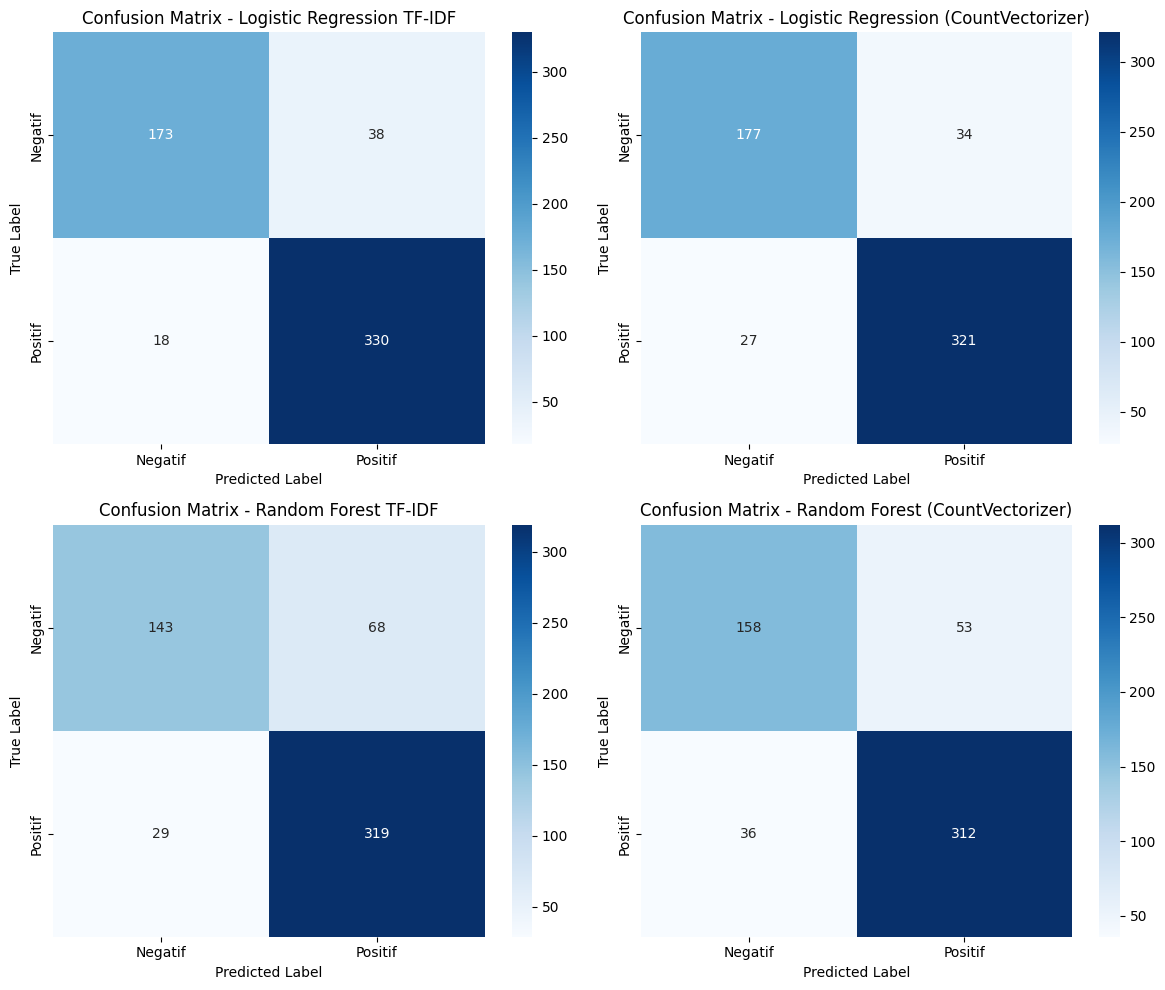

In [63]:
# Membuat confusion matrix untuk masing-masing model
cm_lr_tfidf = confusion_matrix(y_test_tfidf, y_pred_test_lr_tfidf)
cm_lr_cv = confusion_matrix(y_test_cv, y_pred_test_lr_cv)
cm_rf_tfidf = confusion_matrix(y_test_tfidf, y_pred_test_rf_tfidf)
cm_rf_cv = confusion_matrix(y_test_cv, y_pred_test_rf_cv)

# Menyimpan confusion matrix dalam list
cm_list = [cm_lr_tfidf, cm_lr_cv, cm_rf_tfidf, cm_rf_cv]
titles = [
    'Confusion Matrix - Logistic Regression TF-IDF',
    'Confusion Matrix - Logistic Regression (CountVectorizer)',
    'Confusion Matrix - Random Forest TF-IDF',
    'Confusion Matrix - Random Forest (CountVectorizer)'
]

# Membuat subplots dengan 2 baris dan 2 kolom
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Loop untuk visualisasi keempat confusion matrix
for i, ax in enumerate(axes.flat):
    sns.heatmap(cm_list[i], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'], ax=ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title(titles[i])

# Menyesuaikan layout agar tidak ada elemen yang saling tumpang tindih
plt.tight_layout()
plt.show()

Membuat confusion matrix untuk model dengan menggunakan SMOTE

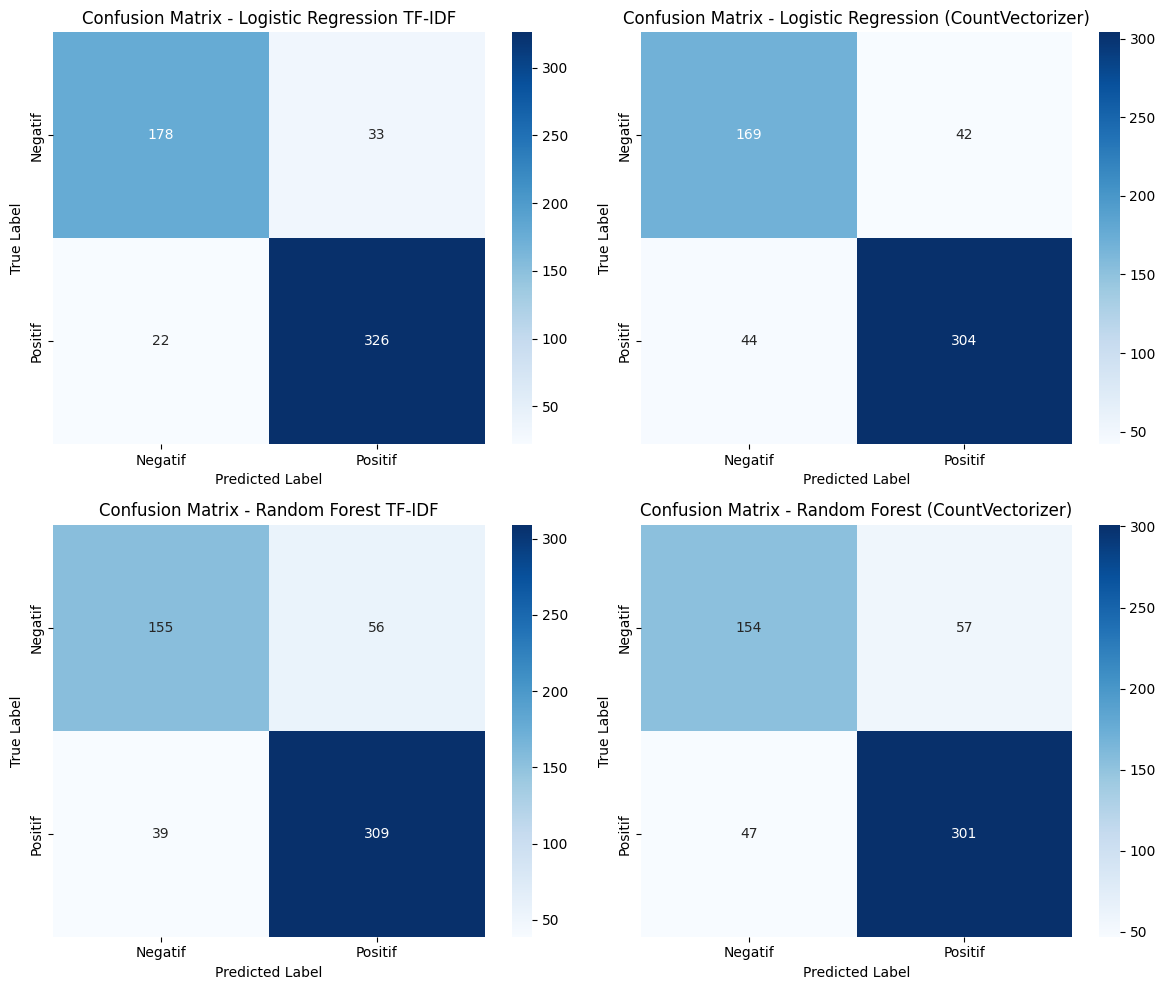

In [64]:
# Membuat confusion matrix untuk masing-masing model
cm_lr_tfidf_smote = confusion_matrix(y_test_tfidf, y_pred_test_lr_tfidf_smote)
cm_lr_cv_smote = confusion_matrix(y_test_cv, y_pred_test_lr_cv_smote)
cm_rf_tfidf_smote = confusion_matrix(y_test_tfidf, y_pred_test_rf_tfidf_smote)
cm_rf_cv_smote = confusion_matrix(y_test_cv, y_pred_test_rf_cv_smote)

# Menyimpan confusion matrix dalam list
cm_list = [cm_lr_tfidf_smote, cm_lr_cv_smote, cm_rf_tfidf_smote, cm_rf_cv_smote]
titles = [
    'Confusion Matrix - Logistic Regression TF-IDF',
    'Confusion Matrix - Logistic Regression (CountVectorizer)',
    'Confusion Matrix - Random Forest TF-IDF',
    'Confusion Matrix - Random Forest (CountVectorizer)'
]

# Membuat subplots dengan 2 baris dan 2 kolom
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Loop untuk visualisasi keempat confusion matrix
for i, ax in enumerate(axes.flat):
    sns.heatmap(cm_list[i], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'], ax=ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title(titles[i])

# Menyesuaikan layout agar tidak ada elemen yang saling tumpang tindih
plt.tight_layout()
plt.show()

# Hasil dan Interpretasi

Berdasarkan analisis yang dilakukan, kesimpulan utamanya adalah penerapan teknik SMOTE secara signifikan meningkatkan performa model dengan mengatasi ketidakseimbangan data, yang terbukti dari lonjakan F1-Score dari sekitar 87% menjadi 91%. Model terbaik yang dihasilkan adalah kombinasi Logistic Regression dengan ekstraksi fitur TF-IDF dan penyeimbangan SMOTE, yang berhasil mencapai akurasi 91.3% dan F1-Score tertinggi sebesar 91.1%. Kombinasi ini direkomendasikan karena tidak hanya memiliki akurasi tinggi, tetapi juga memberikan kemampuan prediksi yang paling seimbang dan andal dalam mengidentifikasi ulasan sentimen positif maupun negatif, menjadikannya solusi yang paling efektif dan praktis untuk dataset ini.

# Word Cloud


Sebagai langkah visualisasi tambahan, word cloud dibuat untuk ulasan positif dan negatif secara terpisah. Ini memberikan gambaran visual mengenai kata-kata yang paling sering muncul dalam setiap kategori sentimen, sehingga memudahkan pemahaman mengenai tema utama dari umpan balik pengguna.

In [65]:
# Menyaring ulasan dengan polaritas positif
positive_review = reviews_df[reviews_df['polarity'] == 'positive']
positive_review = positive_review[['Stemmed_Text', 'polarity_score', 'polarity','Stopword']]
positive_review = positive_review.sort_values(by='polarity_score', ascending=False)
positive_review = positive_review.reset_index(drop=True)
positive_review.index += 1

In [66]:
# Menyaring ulasan dengan polaritas negative
negative_review = reviews_df[reviews_df['polarity'] == 'negative']
negative_review = negative_review[['Stemmed_Text', 'polarity_score', 'polarity','Stopword']]
negative_review = negative_review.sort_values(by='polarity_score', ascending=False)
negative_review = negative_review.reset_index(drop=True)
negative_review.index += 1

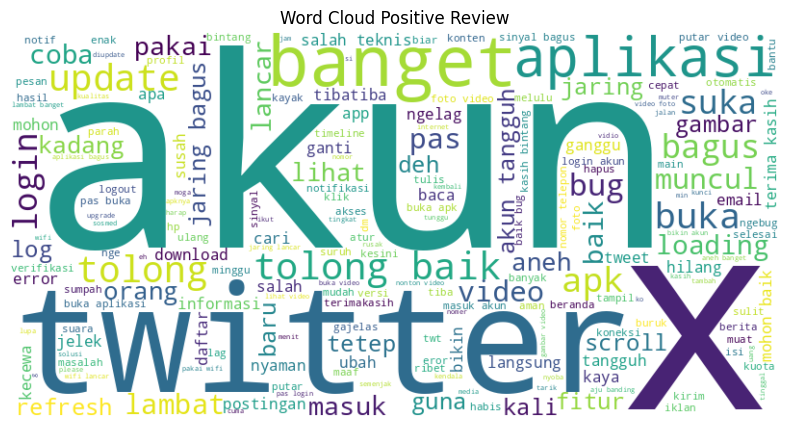

In [67]:
# Menampilkan kata kata positive yang sering muncul
word = ' '.join(positive_review['Stemmed_Text'].astype(str))

# Buat WordCloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200
).generate(word)

# Tampilkan dengan matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Positive Review')
plt.show()

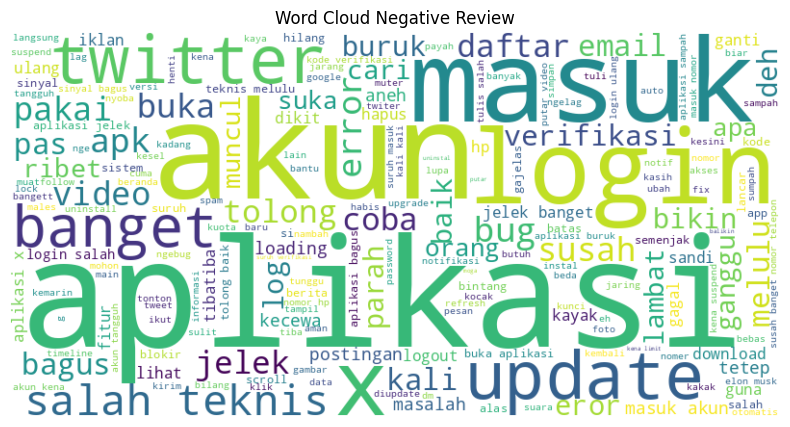

In [68]:
# Menampilkan kata kata negative yang sering muncul
word = ' '.join(negative_review['Stemmed_Text'].astype(str))

# Buat WordCloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200
).generate(word)

# Tampilkan dengan matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Negative Review')
plt.show()